<a href="https://colab.research.google.com/github/COGS108/group19_sp20/blob/master/FinalProject_group19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Individual Amazon Product Ratings With Customer Reviews

# Overview

At this time, online shopping and e-commerce has experienced a huge increase in interest and business due to its convenience and broad range of available products. It has become part of the role of a consumer to leave ratings and reviews in order to inform other people of the pros and cons of certain products, influencing other customers' decisions. For our project, we decided to use natural language processing (NLP) in order to determine if we could predict indiviual Amazon product ratings based off of customers' reviews and see how well our model can perform compared to the actual ratings. Our original idea involved determining if we could predict ratings based on product titles, as product titles can improve clickthrough rate and customer decisions. However, we see later in our analysis that product titles did not have a clear pattern connected to the ratings that would warrant a prediction model, so we looked into reviews. In order to do this, we found an dataset of all the metadata, ratings, and reviews for each category within Amazon Shopping(ie. Fashion, Electronics, etc) from a research team at UCSD. We created our own rating prediction model based off of a feature matrix using TF-IDF, BoW, and other text features we extracted from the reviews. 

# Names

- Chase Sriprajittichai
- Michelle Chang
- Shilpita Biswas
- Rachael Ehlen

# Research Question

Review Analysis: Can we accurately predict ratings using customer reviews and our own rating prediction model? 


## Background and Prior Work

As online shopping becomes more prevalent and Amazon being one of the top companies in e-commerce, we thought it would be interesting to look into Amazon product and review data since our online shopping choices are largely dictated by ratings and reviews. We initially chose to only analyze the effect of title length of the products on their ratings, but the results were not very substantial. Product title length and rating were very loosely correlated, so we chose to bring our attention to the reviews. It is generally understood that reviews that have more positive things to say about a product are associated with a higher rating whereas more negative reviews generally have lower ratings. Since there is vast amount of variation in what people say about a product and what they ultimately rate it, we wanted to see if we could formally predict the rating from the review with relatively high accuracy using a model that analyses the words used in the review.

We have found a similar study that uses Amazon product reviews and sees if they align with a user’s interest in the product. This study uses two different models to recognize keywords in reviews and concludes if the reviews justify the user’s decision to buy the product. The reference for the original study is included below as well as the Dataset section.

Another group conducted a study that also used Amazon product reviews in which they applied different machine learning algorithms to see which one was a better model for classifying whether the review was positive or negative. Specifally, SVM and Naive Bayes were used on Amazon beauty product reviews. They concluded that the SVM method produced slightly more accurate results. From their study's conclusion, we saw that we could apply the SVM model that we have learned in class to make a model of our own that classifies the reviews into their respective ratings, taking it one step further from positive and negative classification. The reference for the study paper is included below.

References:
- 1) Justifying recommendations using distantly-labeled reviews and fined-grained aspects
Jianmo Ni, Jiacheng Li, Julian McAuley
Empirical Methods in Natural Language Processing (EMNLP), 2019 https://nijianmo.github.io/amazon/index.html?fbclid=IwAR06O1wKVQye-fDctfTy1azCbAzvfbQzM-4U2Xz7aBQezr6V1VwlgLEYVmg

- 2) Paknejad, Sepideh. “Sentiment Classification on Amazon Reviews Using Machine Learning Approaches.” Https://Www.diva-Portal.org/, 2018, www.diva-portal.org/smash/get/diva2:1241547/FULLTEXT01.pdf.

# Hypothesis


We predict we will be able to predict customer ratings accurately using NLP features such as TF-IDF and ML models such as K-neighbors classification and SVM. One major hindrance will be that there is an inherent flaw in the rating system: ratings can be very subjective and not match the review's sentiment, which could lead to predicted ratings that are too high or too low. This will contribute to the possibility that our model may not perform as well as we may want it to(above 70%-80%). 

# Dataset(s)

Dataset 1:
- Name: meta_AMAZON_FASHION
- Link: https://nijianmo.github.io/amazon/index.html?fbclid=IwAR06O1wKVQye-fDctfTy1azCbAzvfbQzM-4U2Xz7aBQezr6V1VwlgLEYVmg
- Number of Observations: 883,636
- Description: This is the dataset that includes the metadata for Amazon products in the fashion category such as name and product ID.

Dataset 2: 
- Name: AMAZON_FASHION.csv
- Link: https://nijianmo.github.io/amazon/index.html?fbclid=IwAR06O1wKVQye-fDctfTy1azCbAzvfbQzM-4U2Xz7aBQezr6V1VwlgLEYVmg
- Number of Observations: 883,636
- Description: This is the dataset that includes the ratings of products from individual customers

Dataset 3:
- Name: AMAZON_FASHION.json
- Link: https://nijianmo.github.io/amazon/index.html?fbclid=IwAR06O1wKVQye-fDctfTy1azCbAzvfbQzM-4U2Xz7aBQezr6V1VwlgLEYVmg
- Number of Observations: 883,636
- Description: This is the dataset that includes the reviews and summary titles for each review and each product. It consists of product, product ID, reviewer, reviewer ID, review, summary, style of product, image of product, time the review was made, and the rating given by the reviewer. 

We originally used the first two datasets for our initial experiment on product titles, and we combined them on the basis of the product ID. We did this in order to make sure we would have adequate product titles and supplemental data to analyze. In the end, product title analysis proved to not lead to significant conclusions, so we used the third dataset to analyze reviews and predict ratings. 

# Setup

In [1]:
import os
import json
import gzip
import string
import warnings
from typing import Callable, Dict, List, Tuple
from urllib.request import urlopen
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import FeatureHasher
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors
import numpy as np
from sklearn.manifold import TSNE
import numpy as np
from scipy import sparse
from wordcloud import WordCloud
import itertools
import matplotlib.patches as patches

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /Users/shilpita/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shilpita/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/shilpita/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
warnings.filterwarnings('ignore')

## Why We Changed to Reviews
The plots below were the results of our analysis comparing title length and rating. As you can see, there was no strong correlation between the two variables. Both the title and the rating were relatively normally distributed around the most popular length and number of stars, respectively. Even when plotted against each other (both figures below), no trend emerged. If you examine the rating distribution for the titles with very high or low word counts, the datapoints are scattered across all ratings and look relatively random. Ratings were most commonly 5 stars and titles were commonly under 20 words, both of which was clear in their individual plots. Since plotting them against each other revealed no further correlation, we chose to shift our focus towards analyzing the reviews and looking for correlations within that dataset.

<img src="Plot1.png">

<img src="./Plot2.png">

# Data Cleaning

## Data

Our data was already scraped by the research team at UCSD, so we already had available datasets thst we could download.

We decided to look at the reviews dataset for the fashion category within Amazon shopping because the dataset was relatively small  

In [4]:
reviews = pd.read_json('AMAZON_FASHION.json', lines = True)

In [5]:
reviews.head(10)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN
1,2,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,3.0,NaN,NaN
2,4,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,NaN,NaN,NaN
3,2,True,"08 24, 2014",A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400,NaN,NaN,NaN
4,3,False,"07 27, 2014",A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,1406419200,NaN,NaN,NaN
5,5,True,"07 19, 2014",A29HLOUW0NS0EH,7106116521,Patricia R. Erwin,Exactly what I wanted.,Five Stars,1405728000,NaN,NaN,NaN
6,4,True,"05 31, 2014",A7QS961ROI6E0,7106116521,REBECCA S LAYTON,These little plastic backs work great. No mor...,Works great!,1401494400,NaN,NaN,NaN
7,3,True,"09 22, 2013",A1BB77SEBQT8VX,B00007GDFV,Darrow H Ankrum II,mother - in - law wanted it as a present for h...,bought as a present,1379808000,NaN,{'Color:': ' Black'},NaN
8,3,True,"07 17, 2013",AHWOW7D1ABO9C,B00007GDFV,rosieO,"Item is of good quality. Looks great, too. But...",Buxton heiress collection,1374019200,NaN,{'Color:': ' Black'},NaN
9,3,True,"04 13, 2013",AKS3GULZE0HFC,B00007GDFV,M. Waltman,I had used my last el-cheapo fake leather ciga...,Top Clasp Broke Within 3 days!,1365811200,NaN,{'Color:': ' Black'},NaN


In [6]:
reviews.shape

(883636, 12)

## Clean Data

### Steps to Clean Data:

1. Remove columns with times reviews were made, reviewer IDs, product IDs, reviewer names, styles of the product, images, and any other unnecessary columns. 
3. Remove nulls
4. Remove punctuation of reviews and lowercase them
5. Tokenize reviews and summaries of reviews, remove stop words, and stem review words

In [7]:
#Remove punctuation from reviews
def remove_punctuation(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [8]:
#Lowercase words in reviews-function originally used for titles
def lowercase_titles(text):
    text = text.lower()
    return text

In [9]:
reviews = reviews.drop(columns = ['reviewTime', 'reviewerID', 'asin', 'reviewerName', 'unixReviewTime', 'vote', 
                                  'style', 'image'])
reviews = reviews.rename(columns={ 'reviewText': 'review' })

In [10]:
reviews.head(10)

,overall,verified,review,summary
0,5,True,Exactly what I needed.,perfect replacements!!
1,2,True,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ..."
2,4,False,Love these... I am going to order another pack...,My New 'Friends' !!
3,2,True,too tiny an opening,Two Stars
4,3,False,Okay,Three Stars
5,5,True,Exactly what I wanted.,Five Stars
6,4,True,These little plastic backs work great. No mor...,Works great!
7,3,True,mother - in - law wanted it as a present for h...,bought as a present
8,3,True,"Item is of good quality. Looks great, too. But...",Buxton heiress collection
9,3,True,I had used my last el-cheapo fake leather ciga...,Top Clasp Broke Within 3 days!


In [11]:
reviews.isna().sum()

overall        0
verified       0
review      1233
summary      533
dtype: int64

In [12]:
#remove null rows
reviews = reviews.dropna(how='any')

In [13]:
# Reduce size of dataset

N_REVIEWS = 40000

reviews = reviews.sample(N_REVIEWS, random_state=1)

reviews = reviews.reset_index(drop=True)

In [14]:
#Check data types in each column
reviews.dtypes

overall      int64
verified      bool
review      object
summary     object
dtype: object

In [15]:
#lowercase letters
reviews['review'] = reviews['review'].apply(lowercase_titles)
reviews['summary'] = reviews['summary'].apply(lowercase_titles)

In [16]:
#tokenize, remove stop words, and stem summaries
ps = PorterStemmer()
reviews['summaries_tokenized'] = reviews['summary'].apply(word_tokenize)
reviews['summaries_no_stop'] = reviews['summaries_tokenized'].apply(lambda x: [item for item in x if item not in stop_words])
reviews['no_stop_stem_sum'] = reviews['summaries_no_stop'].apply(lambda x: [ps.stem(y) for y in x])

In [17]:
reviews['review_tokenized'] = reviews['review'].apply(word_tokenize)
reviews['review_no_stop'] = reviews['review_tokenized'].apply(lambda x: [item for item in x if item not in stop_words])
reviews['review_no_stop_stem'] = reviews['review_no_stop'].apply(lambda x: [ps.stem(y) for y in x])

In [18]:
reviews.head()

,overall,verified,review,summary,summaries_tokenized,summaries_no_stop,no_stop_stem_sum,review_tokenized,review_no_stop,review_no_stop_stem
0,3,True,"this is nice dress, but the sizing is totally ...","this is nice dress, but the sizing is totally off","[this, is, nice, dress, ,, but, the, sizing, i...","[nice, dress, ,, sizing, totally]","[nice, dress, ,, size, total]","[this, is, nice, dress, ,, but, the, sizing, i...","[nice, dress, ,, sizing, totally, ., knew, rev...","[nice, dress, ,, size, total, ., knew, review,..."
1,1,True,way too small!! xl fits like a medium... this ...,too small,"[too, small]",[small],[small],"[way, too, small, !, !, xl, fits, like, a, med...","[way, small, !, !, xl, fits, like, medium, ......","[way, small, !, !, xl, fit, like, medium, ...,..."
2,5,True,perfect all around! exactly like the description.,five stars,"[five, stars]","[five, stars]","[five, star]","[perfect, all, around, !, exactly, like, the, ...","[perfect, around, !, exactly, like, descriptio...","[perfect, around, !, exactli, like, descript, .]"
3,5,True,i purchased this dress sometime ago and i abso...,very stylish. perfectly fitted dress!,"[very, stylish, ., perfectly, fitted, dress, !]","[stylish, ., perfectly, fitted, dress, !]","[stylish, ., perfectli, fit, dress, !]","[i, purchased, this, dress, sometime, ago, and...","[purchased, dress, sometime, ago, absolutely, ...","[purchas, dress, sometim, ago, absolut, love, ..."
4,5,True,love this jacket!! i have received multiple co...,love this jacket,"[love, this, jacket]","[love, jacket]","[love, jacket]","[love, this, jacket, !, !, i, have, received, ...","[love, jacket, !, !, received, multiple, compl...","[love, jacket, !, !, receiv, multipl, complime..."


In [19]:
review_words = reviews['no_stop_stem_sum'].apply(pd.Series).stack()

## Exploratory and Descriptive Analyses

For our exploratory and descriptive analyses, we decided to look into the most common words within reviews and review sentiment, since we will consider using these as features within our rating prediction model.

### Word Frequency

In [20]:
# calculation word frequency
fdist_reviews = FreqDist(review_words)

# remove punctuation counts
for punc in string.punctuation:
    del fdist_reviews[punc]

In [21]:
#Get only first 85 words for wordcloud
fdist_reviews_needed = dict(itertools.islice(dict(fdist_reviews).items(), 85))

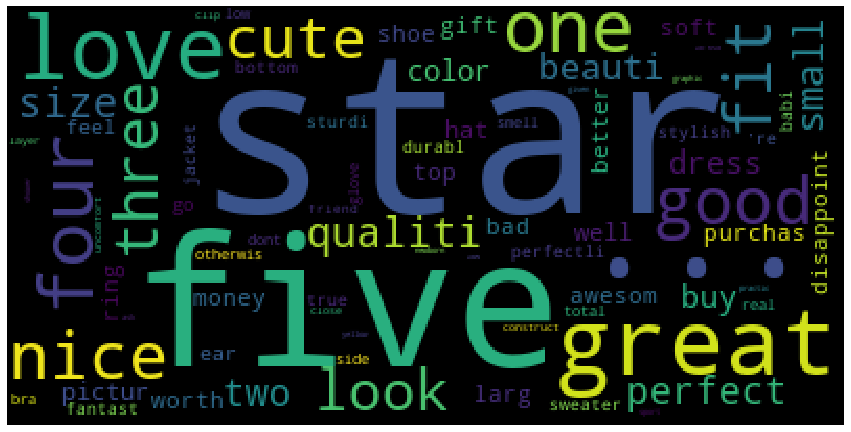

In [22]:
#Wordcloud to visualize most frequent words in reviews
wordcloud = WordCloud().generate_from_frequencies(fdist_reviews_needed)
plt.imshow(wordcloud)
plt.axis("off")
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

In [23]:
# sort the words by their frequency in descending order
sorted_freq = {k: v for k, v in sorted(fdist_reviews.items(), key=lambda item: item[1], reverse=True)}
# get top 20 most frequently used words
first20 = {k: sorted_freq[k] for k in list(sorted_freq)[:20]}

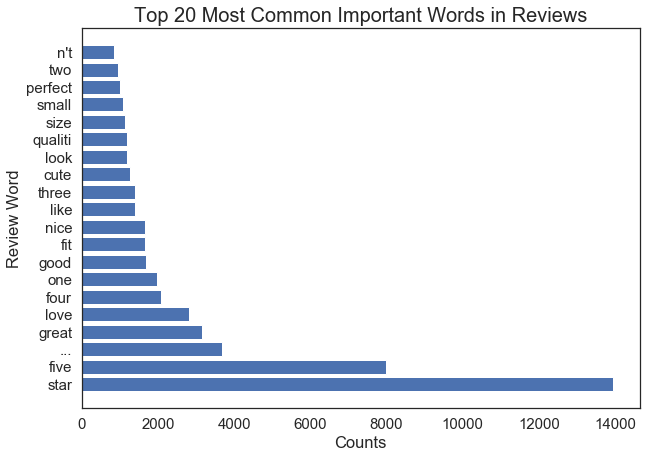

<Figure size 1080x576 with 0 Axes>

In [73]:
# plot of top 20 most common words in reviews
plt.barh(list(first20.keys()), list(first20.values()))
sns.set(rc={'figure.figsize':(8, 7)}, style = 'white')
plt.ylabel('Review Word', fontsize = 16.5)
plt.xlabel('Counts', fontsize = 16.5)
plt.title('Top 20 Most Common Important Words in Reviews', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.figure(figsize=(15, 8))
plt.show()

The most common words in the subset of the reviews dataset we have examined related to the ratings themselves or feelings towards the product. Although these are the most frequent words within reviews after removing stop words, some of them may still not be useful when we create our prediction model. For example, "star" is the most common word within our subset, but a review that contains that word can easily be positive or negative. If we base our prediction model on just common words, the predicted ratings will not be accurate, which is why we decided to look into the ratings of our dataset overall and review sentiment. 

### Distribution of Ratings

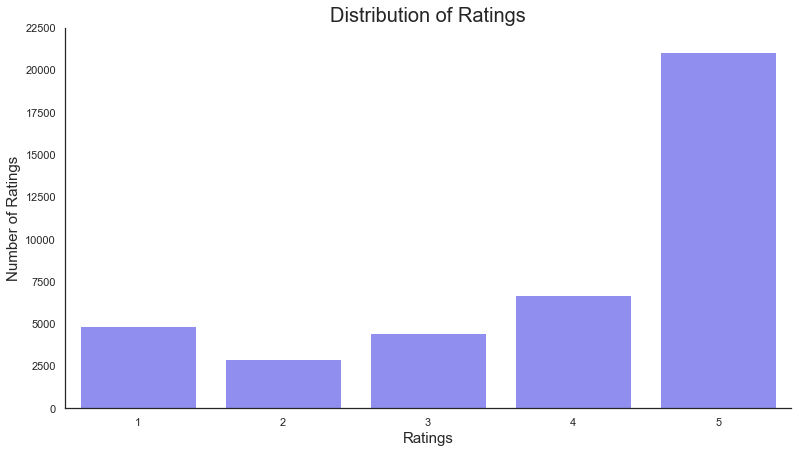

In [86]:
#Distribution of Ratings
palette = sns.color_palette("cool", 1)
plot = sns.countplot(x = 'overall', data=reviews, palette = palette)
plot.set_title('Distribution of Ratings', fontsize = 20)
plot.set_xlabel('Ratings', fontsize = 15)
plot.set_ylabel('Number of Ratings', fontsize = 15)
sns.set(rc={'figure.figsize':(13,7)}, style = 'white')
plot.set_yticks(plot.get_yticks())
sns.despine()

This plot shows us that the number of 5-star ratings is extremely large relative to the number of ratings for other categories, which wouldn't be supported or predicted by our model if we only looked at most frequent words. How would a review containing the words "one" and "star" really be able to accurately predict a 5-star rating if that is the rating the product has received? This is why we also decided to look into the sentiment analysis of the reviews.

### Sentiment Analysis

In [26]:
#For sentiment analysis of reviews
def get_sentiments(input_list):
    
    output = pd.DataFrame()

    for sentence in input_list:
        ss = analyser.polarity_scores(sentence)
        ss['sentence'] = sentence
        output = output.append(ss, ignore_index=True)

    return output

In [27]:
analyser = SentimentIntensityAnalyzer()
review_sentiments = get_sentiments(list(reviews['review'].values))

In [28]:
review_sentiments.head(10)

,compound,neg,neu,pos,sentence
0,0.2263,0.000,0.936,0.064,"this is nice dress, but the sizing is totally ..."
1,0.3871,0.000,0.866,0.134,way too small!! xl fits like a medium... this ...
2,0.7574,0.000,0.435,0.565,perfect all around! exactly like the description.
3,0.9191,0.035,0.714,0.251,i purchased this dress sometime ago and i abso...
4,0.8802,0.000,0.625,0.375,love this jacket!! i have received multiple co...
5,0.5719,0.000,0.000,1.000,perfect
6,0.4215,0.000,0.263,0.737,nice product
7,0.5665,0.117,0.671,0.212,"he normally wears a 2t, thought i'll go up a s..."
8,0.8577,0.000,0.586,0.414,great shirt and very good print quality!!\ndef...
9,-0.8641,0.271,0.687,0.042,good quality not cheap as expected but the col...


In [29]:
reviews['sentiment_reviews_compound'] = review_sentiments['compound']
reviews['sentiment_reviews_neg'] = review_sentiments['neg']
reviews['sentiment_reviews_neu'] = review_sentiments['neu']
reviews['sentiment_reviews_pos'] = review_sentiments['pos']

In [30]:
review_sentiments.describe()

,compound,neg,neu,pos
count,40000.000000,40000.000000,40000.000000,40000.000000
mean,0.492026,0.042532,0.639876,0.317443
std,0.453337,0.097990,0.248247,0.263955
min,-0.983000,0.000000,0.000000,0.000000
25%,0.226300,0.000000,0.501000,0.116000
50%,0.636900,0.000000,0.688000,0.262000
75%,0.851900,0.046000,0.811000,0.469000
max,0.999300,1.000000,1.000000,1.000000


In [31]:
review_sentiments.shape

(40000, 5)

In [32]:
reviews.isna().sum()

overall                       0
verified                      0
review                        0
summary                       0
summaries_tokenized           0
summaries_no_stop             0
no_stop_stem_sum              0
review_tokenized              0
review_no_stop                0
review_no_stop_stem           0
sentiment_reviews_compound    0
sentiment_reviews_neg         0
sentiment_reviews_neu         0
sentiment_reviews_pos         0
dtype: int64

In [33]:
reviews[reviews.isnull().any(axis=1)]

,overall,verified,review,summary,summaries_tokenized,summaries_no_stop,no_stop_stem_sum,review_tokenized,review_no_stop,review_no_stop_stem,sentiment_reviews_compound,sentiment_reviews_neg,sentiment_reviews_neu,sentiment_reviews_pos


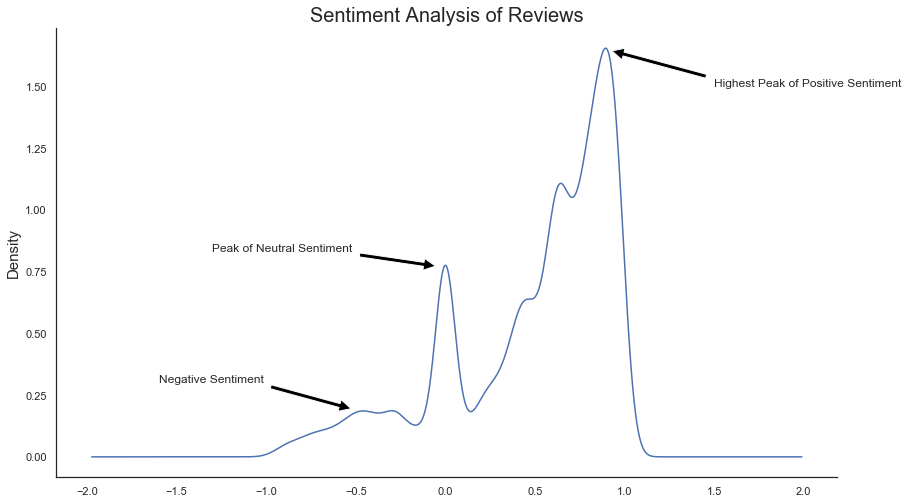

In [91]:
ax = review_sentiments['compound'].plot.density()
sns.set(rc={'figure.figsize':(13,7)}, style = 'white')
ax.set_title('Sentiment Analysis of Reviews', fontsize = 20)
ax.set_ylabel('Density', fontsize = 15)
ax.annotate('Highest Peak of Positive Sentiment', xy=(0.9, 1.65), xytext=(1.5, 1.5), 
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('Peak of Neutral Sentiment', xy=(-0.03, 0.77), xytext=(-1.3, 0.83), 
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('Negative Sentiment', xy=(-0.5, 0.19), xytext=(-1.6, 0.30), 
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

This shows us that the majority of sentiments in reviews are positive, with some peaks at neutral and negative sentiment. This agrees with the distribution of ratings, as the majority are 5-star ratings, and there are peaks at 3, 4, and 1 star ratings. This may skew our model's learning, as it may learn the features of 5-star ratings well, but not the other ratings. Because of this possible occurrence, we will stratify our data so that the train, test, and validation splits will show an even number of each rating for the model to learn off of and predict. Nevertheless, we will be able to use these observations within our feature matrix for our rating prediction model.

### Effect of Verification Status

A small concern we had about the reviews was the fact that the reviews were either supposed to be verified by Amazon or not. If the majority of reviews were not verified, then the integrity of ratings would be questioned, as well as the accuracy of our model, which is why we checked the verification status of the reviews. 

In [35]:
#Convert Verifications
def convert_labels(text):
    if text == True:
        return 1
    elif text == False:
        return 0
    else:
        return text

In [36]:
reviews['verified'] = reviews['verified'].apply(convert_labels)

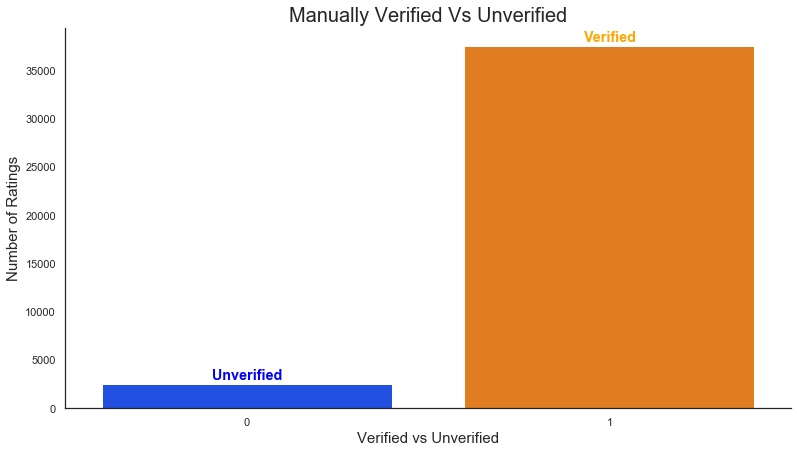

In [89]:
#Distribution of Verifications 
palette = sns.color_palette("bright", 2)
sns.set(rc={'figure.figsize':(13, 7)}, style='white')
viz = sns.countplot(x = 'verified', data = reviews, palette = palette)
viz.set_title('Manually Verified Vs Unverified', fontsize = 20)
viz.set_ylabel('Number of Ratings', fontsize = 15)
viz.set_xlabel('Verified vs Unverified', fontsize = 15)
viz.text(0, 3000, "Unverified", horizontalalignment='center', size='large', color='blue', weight='semibold')
viz.text(1, 38000, "Verified", horizontalalignment='center', size='large', color='orange', weight='semibold')
sns.despine()

The large number of reviews are verified, so this will not be a factor in the integrity of our model.

# Data Analysis & Results

The goal of our data analysis is to create a model that can accurately predict the rating (1-5) of a product, given a text review of the product. The high-level steps of creating and evaluating this model are:
1. Preprocess data that the model needs (data that we can extract features from)
2. Partition the data into a training set (70%), test set (15%), and a validation set (15%) and stratify the data 
3. For each partition, extract features from the data and store them in a feature matrix
4. Train the model on the feature matrix and labels (ratings) of the training set
5. For each partition, use the trained model to predict the labels of each observation in the data
6. For each partition, evaluate the model’s performance by comparing the predicted labels with the actual labels



To see what preprocessing needs to be done, we need to look at what features we have made available:

| Feature | Description | Input type | Output vector length |
|:---|:---|:---|:---|
| verified | 1 if the reviewer is a verified reviewer, 0 otherwise | 0 or 1 | 1 |
| bow      | Bag of words, with a maximum of 2000 features/words | List of words | The number of unique             features/words   found in the training data (max 2000) |
| hashed-bow | The bow feature vector, dimensionality-reduced (by hashing) to 200 features | List of words | 200 |
| tfidf | TF-IDF, with a maximum of 2000 features/words | List of words |  |
| hashed-tfidf | The tfidf feature vector, dimensionality-reduced (by hashing) to 200 features | List of words |     200 |
| sentiment | The four values (compound, negative, neutral, and positive) representing the sentiment of the input | Text | 4                                       |
| word-embeddings | The component-wise average of the word embeddings of the words in the input. Words are only     considered if they are in the vocabulary defined by the pre-trained word embeddings we are using (word2vec). If   no words in the input are in the vocabulary, the output of this feature is a vector of 0s | List of words | 300 |



By outlining the required input types of our features, we can see that all data preprocessing has already been completed during data wrangling, descriptive analysis, and exploratory data analysis. So, step 1 is already complete. Also, from our feature descriptions, we can see that some of our features - **verified** and **sentiment** - have already been computed and are stored in the **reviews** dataframe. All of the other features that haven’t been computed yet - **bow**, **hashed-bow**, **tfidf**, **hashed-tfidf**, and **word-embeddings** - all require tokenized text as input. Like before, we have already tokenized each review and stored it in the **reviews** dataframe.



To enable efficient and configurable model experimentation, we decided to build out a mini model training pipeline, containing stages for feature extraction and model training. In the feature extraction stage, we can specify exactly what features to use in the model, and what data those features are extracted/computed from. Implementation-wise, this feature extraction stage does the following: for each (feature, input data) pair, compute the feature matrix from the input data; once all feature matrices are computed, combine them into one feature matrix that contains all the desired features of the input. This feature matrix is then used in the model training stage as training data for the specified model (KNN or SVM). After completing our mini model training pipeline, we can now use our trained model to make predictions which we can then use to evaluate the model.



For an example of the mini model training pipeline, suppose that you want to create a KNN model that uses **sentiment** and **word-embeddings** features, that is trained on your training set of size **N**. As input to the **sentiment** feature, for each observation, you should pass the four sentiment analysis values (compound, negative, neutral, positive) of the review as input data; as input to the **word-embeddings** feature, for each observation, you should pass the tokenized review as input data. The pipeline will compute the **sentiment** feature matrix (shape (**N**, 4)), followed by the **word-embeddings** feature matrix (shape (**N**, 300)). Then, the pipeline will combine (horizontally stack/append) the two feature matrices into one final feature matrix (shape (**N**, 304)). The pipeline will then use the final feature matrix, as well as the labels (ratings) of the training data, to train a KNN model that is returned to you.

## Pipeline: partition data (train, test, validation)

#### Create function that given a dataframe, partitions 70% of it into a training set, 15% into a test set, and 15% into a validation set

In [38]:
def partition_df(df) -> Tuple[pd.DataFrame]:
    train, test_and_validate = train_test_split(df, test_size=0.3, shuffle=True, stratify = reviews['overall'])
    test, validate = train_test_split(test_and_validate, test_size=0.5)
    return (train, test, validate)

## Pipeline: feature extraction

#### Create feature extraction methods

In [39]:
# Reviewer verified

def create_verified_matrix(verified: List[int], vectorizer=None) -> Tuple[np.ndarray, None]:
    return (np.array(verified).reshape(-1, 1), None)

In [40]:
# Hashes (dimensionality reduction) term-document matrices to have a reduced number of features/columns (default 200)
def hash_term_document_matrix(term_document_matrix: np.ndarray, n_features: int = 200) -> np.ndarray:
    feature_value_dicts: List[Dict[str, float]] = []
    for v in term_document_matrix:
        feature_value_dict: Dict[str, float] = {}
        for feature_ndx, value in enumerate(v):
            feature_value_dict[str(feature_ndx)] = value
        feature_value_dicts.append(feature_value_dict)

    return FeatureHasher(n_features).fit_transform(X=feature_value_dicts).toarray()

In [41]:
# Bag of words, hashed bag of words

def create_bow_term_document_matrix(tokenized_docs: List[List[str]], vectorizer=None) -> Tuple[np.ndarray, CountVectorizer]:
    if vectorizer is None:
        # Create vectorizer. Assume tokenizing and lowercasing has already been done
        no_op = lambda x: x
        vectorizer: CountVectorizer = CountVectorizer(tokenizer=no_op, lowercase=False, max_features=2000)
        vectorizer.fit(tokenized_docs)
    
    # transform returns a sparse matrix. Convert return value to a numpy array
    X = vectorizer.transform(tokenized_docs).toarray()
    
    return (X, vectorizer)


def create_hashed_bow_term_document_matrix(tokenized_docs: List[List[str]], vectorizer=None) -> Tuple[np.ndarray, CountVectorizer]:
    if vectorizer is None:
        X, new_vectorizer = create_bow_term_document_matrix(tokenized_docs)
    else:
        X, new_vectorizer = create_bow_term_document_matrix(tokenized_docs, vectorizer)
    
    X = hash_term_document_matrix(X)
    
    return (X, vectorizer)

In [42]:
# TF-IDF, hashed TF-IDF

def create_tfidf_term_document_matrix(tokenized_docs: List[List[str]], vectorizer=None) -> Tuple[np.ndarray, TfidfVectorizer]:
    if vectorizer is None:
        # Create vectorizer. Assume tokenizing and lowercasing has already been done
        no_op = lambda x: x
        vectorizer: TfidfVectorizer = TfidfVectorizer(tokenizer=no_op, lowercase=False, max_features=2000)
        vectorizer.fit(tokenized_docs)
    
    # transform returns a sparse matrix. Convert return value to a numpy array
    X = vectorizer.transform(tokenized_docs).toarray()
    
    return (X, vectorizer)


def create_hashed_tf_idf_term_document_matrix(tokenized_docs: List[List[str]], vectorizer=None) -> Tuple[np.ndarray, TfidfVectorizer]:
    if vectorizer is None:
        X, new_vectorizer = create_tfidf_term_document_matrix(tokenized_docs)
    else:
        X, new_vectorizer = create_tfidf_term_document_matrix(tokenized_docs, vectorizer)

    X = hash_term_document_matrix(X)
    
    return (X, vectorizer)

In [43]:
# Sentiment analysis

def sentiment_matrix(text, vectorizer = None) -> Tuple[np.ndarray, None]:
    return (text, vectorizer)

In [44]:
# Word embeddings

def create_word_embeddings_matrix(tokenized_docs: List[List[str]], vectorizer=None) -> Tuple[np.ndarray, None]:
    # Load word2vec pre-trained vectors from file
    word2vec_fname = 'GoogleNews-vectors-negative300.bin'
    keyed_vectors: Word2VecKeyedVectors = KeyedVectors.load_word2vec_format(fname=word2vec_fname, binary=True)
    
    # Use pre-defined vocab
    vocab = keyed_vectors.vocab
    
    # Build feature matrix
    X: List[List[float]] = []
    for tokenized_doc in tokenized_docs:
        # word_vectors is list of the word embeddings for each word in tokenized_doc that is in the vocab
        word_vectors: List[np.ndarray] = [keyed_vectors.get_vector(token) for token in tokenized_doc if token in vocab]
        
        # If there is at least one word embedding in word_vectors, then doc_vector is an average
        # of the word embeddings in word_vectors. If word_vectors is empty, doc_vector is a length
        # 300 zero-vector.
        doc_vector: List[float] = []
        if len(word_vectors) > 0:
            # Average word vectors
            n_components = len(word_vectors[0])
            for i in range(n_components):
                component_sum = 0
                for word_vector in word_vectors:
                    component_sum += word_vector[i]
                doc_vector.append(component_sum / len(word_vectors))
        else:
            doc_vector = [0] * 300

        X.append(doc_vector)

    return (np.array(X), None)

#### Map features (strings) to feature extraction functions

In [45]:
# Create map mapping feature names (strings) to their corresponding feature extraction functions
feature_fit_functions: Dict[str, Callable] = {
    'verified': create_verified_matrix,
    'bow': create_bow_term_document_matrix,
    'hashed-bow': create_hashed_bow_term_document_matrix,
    'tfidf': create_tfidf_term_document_matrix,
    'hashed-tfidf': create_hashed_tf_idf_term_document_matrix,
    'sentiment': sentiment_matrix,
    'word-embeddings': create_word_embeddings_matrix
}

#### Create function that creates a feature matrix, given a set of features and the input data for those features

In [46]:
# Param features: maps feature names to the data (must not be none) to compute the feature
# Param feature_vectorizers: maps feature names to existing vectorizers used by the feature
# Returns a tuple of: (1) the feature matrix, (2) vectorizers, that has been updated if new vectorizers were created
def featurize(features: Dict[str, any], vectorizers: Dict[str, object] = None) -> Tuple[np.ndarray, Dict[str, object]]:
    if vectorizers == None:
        vectorizers = {}
    
    # feature_matrices contains all the feature matrices
    # len(feature_matrices) == len(features)
    feature_matrices: List[np.ndarray] = []
    for feature, data in features.items():
        if feature not in feature_fit_functions:
            raise Exception(f'Unkown feature {feature}')
        #if data is None:
            #raise Exception(f'Cannot do {feature} featurization on no data')
        
        # If a vectorizer is given, use it (do not create a new vectorizer, if applicable).
        # Otherwise, if a vectorizer is not applicable to the current feature or a
        # vectorizer does not exist, create the feature matrix and return a vectorizer if
        # one was created.
        if feature in vectorizers:
            print(f'In featurize. Using existing vectorizer for {feature}')
            
            # Compute feature matrix using existing vectorizer
            existing_vectorizer = vectorizers[feature]
            X, new_vectorizer = feature_fit_functions[feature](data, existing_vectorizer)
        else:
            print(f'In featurize. Not using existing vectorizer for {feature}')
            
            # Compute feature matrix for current feature, without an existing vectorizer
            X, new_vectorizer = feature_fit_functions[feature](data)
            
        # If a vectorizer was created, add it to vectorizers
        if new_vectorizer is not None:
            vectorizers[feature] = new_vectorizer
            
        # Add just-computed feature matrix to feature_matrices
        feature_matrices.append(X)
            
    # Stack feature matrices horizontally
    # Suppose we have 350 documents (i.e. reviews), and there are 1000 total words (terms)
    # present in all of the documents. Suppose we called featurize with two features: 'bow'
    # and 'tfidf'. Then, the bag of words feature matrix should have shape (350 rows, 1000
    # columns). The TF-IDF feature matrix should also have shape (350, 1000). The result of
    # horizontally stacking the bag of words feature matrix and the TF-IDF feature matrix
    # should have shape (350, 2000).
    X = np.concatenate(tuple(feature_matrices), axis=1)
    print(f'In featurize. After combining feature matrices, X.shape = {X.shape}')
    
    return (X, vectorizers)

## Pipeline: classification model creation

#### For each available classification model, create a function to create and train the model

In [47]:
# K-nearest neighbors

def train_knn_classifier(X: np.ndarray, y: np.ndarray) -> KNeighborsClassifier:
    clf = KNeighborsClassifier()
    clf.fit(X, y)
    return clf

In [48]:
# SVM

def train_svm_classifier(X: np.ndarray, y: np.ndarray) -> SVC:
    clf = SVC()
    clf.fit(X, y)
    return clf

In [49]:
# Create map mapping model names (strings) to their corresponding model creation + training functions
model_creation_map: Dict[str, Callable] = {
    'knn': train_knn_classifier,
    'svm': train_svm_classifier
}

## Using the pipeline: dataset partitioning, featurization, model training, and prediction

#### Partition data into train, test, and validation

In [50]:
# Partition data

reviews_train, reviews_test, reviews_validate = partition_df(reviews)
reviews_train.shape, reviews_test.shape, reviews_validate.shape

((28000, 14), (6000, 14), (6000, 14))

#### Create feature matrices and output/label arrays for train, test, and validation

In [51]:
# Create X (data matrix) and y (output/label vectors) for train, test, and validation


print('Featurizing train')
X_train, vectorizers_from_train = featurize(
    features={
        'verified': reviews_train['verified'],
#         'hashed-bow': reviews_train['review_no_stop_stem'],
#         'tfidf': reviews_train['review_no_stop_stem'],
        'sentiment': reviews_train[['sentiment_reviews_compound', 'sentiment_reviews_neg', 
                                    'sentiment_reviews_neu', 'sentiment_reviews_pos']],
        'word-embeddings': reviews_train['review_no_stop']
    }
)

print('Featurizing test')
X_test, _ = featurize(
    features={
        'verified': reviews_test['verified'],
#         'hashed-bow': reviews_test['review_no_stop_stem'],
#         'tfidf': reviews_test['review_no_stop_stem'],
        'sentiment': reviews_test[['sentiment_reviews_compound', 'sentiment_reviews_neg', 
                                    'sentiment_reviews_neu', 'sentiment_reviews_pos']],
        'word-embeddings': reviews_test['review_no_stop']
    },
    vectorizers=vectorizers_from_train
)

print('Featurizing validate')
X_validate, _ = featurize(
    features={
        'verified': reviews_validate['verified'],
#         'hashed-bow': reviews_validate['review_no_stop_stem'],
#         'tfidf': reviews_validate['review_no_stop_stem'],
        'sentiment': reviews_validate[['sentiment_reviews_compound', 'sentiment_reviews_neg', 
                                    'sentiment_reviews_neu', 'sentiment_reviews_pos']],
        'word-embeddings': reviews_validate['review_no_stop']
    },
    vectorizers=vectorizers_from_train
)

# Convert dataframes to numpy arrays
y_train = reviews_train['overall'].to_numpy()
y_test = reviews_test['overall'].to_numpy()
y_validate = reviews_validate['overall'].to_numpy()

X_train.shape, X_test.shape, X_validate.shape, y_train.shape, y_test.shape, y_validate.shape

Featurizing train
In featurize. Not using existing vectorizer for verified
In featurize. Not using existing vectorizer for sentiment
In featurize. Not using existing vectorizer for word-embeddings
In featurize. After combining feature matrices, X.shape = (28000, 305)
Featurizing test
In featurize. Not using existing vectorizer for verified
In featurize. Not using existing vectorizer for sentiment
In featurize. Not using existing vectorizer for word-embeddings
In featurize. After combining feature matrices, X.shape = (6000, 305)
Featurizing validate
In featurize. Not using existing vectorizer for verified
In featurize. Not using existing vectorizer for sentiment
In featurize. Not using existing vectorizer for word-embeddings
In featurize. After combining feature matrices, X.shape = (6000, 305)


((28000, 305), (6000, 305), (6000, 305), (28000,), (6000,), (6000,))

#### Create trained classification model

In [52]:
# Create the KNN classifier
knn=train_knn_classifier(X_train, y_train)

#### Use trained model to predict labels for train, test, and validation

In [53]:
pred_train = knn.predict(X_train)
pred_test = knn.predict(X_test)
pred_validate = knn.predict(X_validate)

## Model evaluation

#### Compute precision, recall, and F1 for train, test, and validation

In [54]:
# View performance on training set

print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           1       0.56      0.82      0.66      3421
           2       0.45      0.39      0.42      2031
           3       0.51      0.41      0.45      3137
           4       0.53      0.40      0.46      4670
           5       0.83      0.86      0.85     14741

    accuracy                           0.69     28000
   macro avg       0.58      0.57      0.57     28000
weighted avg       0.69      0.69      0.68     28000



In [55]:
# View performance on test set

print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           1       0.45      0.67      0.54       747
           2       0.19      0.18      0.18       438
           3       0.25      0.19      0.21       692
           4       0.29      0.24      0.26       986
           5       0.77      0.78      0.77      3137

    accuracy                           0.56      6000
   macro avg       0.39      0.41      0.39      6000
weighted avg       0.55      0.56      0.55      6000



In [56]:
# View performance on validation set

print(classification_report(y_validate, pred_validate))

              precision    recall  f1-score   support

           1       0.43      0.65      0.52       719
           2       0.20      0.18      0.19       433
           3       0.23      0.19      0.21       652
           4       0.27      0.21      0.23      1015
           5       0.77      0.78      0.78      3181

    accuracy                           0.56      6000
   macro avg       0.38      0.40      0.38      6000
weighted avg       0.55      0.56      0.55      6000



In [57]:
X_test_tsne = TSNE(n_components=2).fit_transform(X_test)

In [58]:
X_test_tsne.shape

(6000, 2)

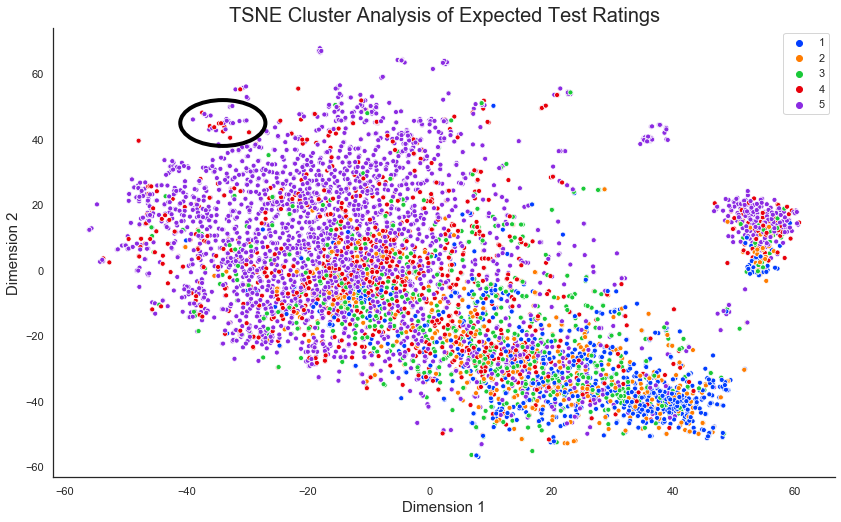

In [95]:
palette = sns.color_palette("bright", 5)
sns.set(rc={'figure.figsize':(14,8.27)}, style='white')
plot = sns.scatterplot(X_test_tsne[:,0], X_test_tsne[:,1], 
                hue=y_test, legend='full', 
                palette=palette, s = 25)
plot.set_title('TSNE Cluster Analysis of Expected Test Ratings', fontsize = 20)
plot.set_xlabel('Dimension 1', fontsize = 15)
plot.set_ylabel('Dimension 2', fontsize = 15)
plot.add_patch(patches.Circle((-34, 45), 7, 
                              alpha=1, edgecolor="black", 
                              linewidth=4, linestyle='solid', fill = False))
sns.despine()

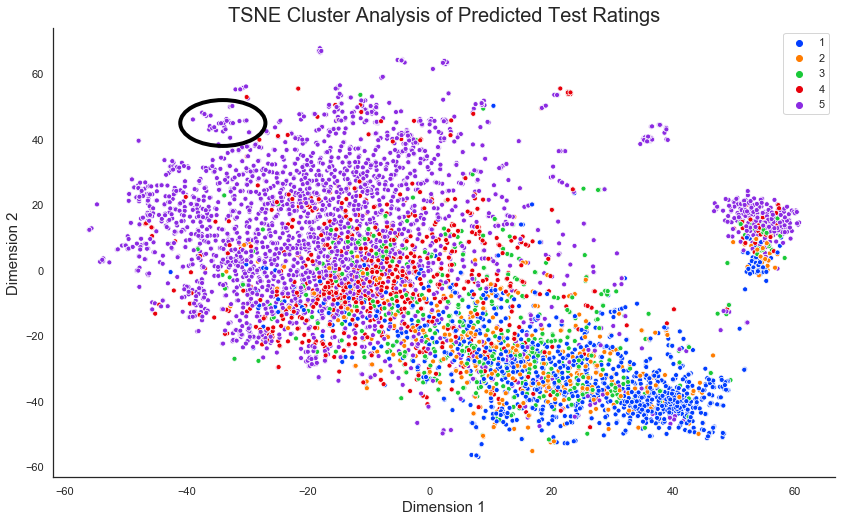

In [96]:
palette = sns.color_palette("bright", 5)
sns.set(rc={'figure.figsize':(14,8.27)}, style = 'white')
ax = sns.scatterplot(X_test_tsne[:,0], X_test_tsne[:,1], 
                     hue=pred_test, legend='full', palette=palette, s = 25)
ax.set_title('TSNE Cluster Analysis of Predicted Test Ratings', fontsize = 20)
ax.set_xlabel('Dimension 1', fontsize = 15)
ax.set_ylabel('Dimension 2', fontsize = 15)
ax.add_patch(patches.Circle((-34, 45), 7, 
                              alpha=1, edgecolor="black", 
                              linewidth=4, linestyle='solid', fill = False))
sns.despine()

In order to visualize our results, we decided to use TSNE cluster analysis to reduce the dimensionality of our feature matrix to 2 features and plot the results using our actual ratings and predicted ratings against those 2 dimensions. The first scatterplot shows the TSNE cluster analysis for the expected test labels, and the second scatterplot shows the same for our predicted test labels using our KNN classifier and feature matrix. Although our model predicted the majority of 5-star ratings fairly well(78% accuracy), it still didn't perform as well as we thought it would overall(57% overall accuracy). Part of this is due to the way ratings are clustered. For example, the black circles in both plots represent the same points. In the expected plot, there are two different ratings: 4 star and 5 star. However, due to the nature of KNN and the distance between each point, our model predicted those points to be the same label(5-star). This is evident throughout the predicted visualization: the scattering of different ratings throughout the purple cloud of 5-star ratings in the expected plot were predicted to be 5-star points in our predicted plot. An explanation for this prediction offset in terms of reviews is that ratings are simply subjective. 3 different ratings can give off the same sentiment and use the same words, but all three reviewers might end up giving different ratings, which is the nature of consumerism and subjectivity within online shopping. Nevertheless, the rating system is so open-ended and vague that predictions like these can still be used and be fairly accurate, and the model can be further fine-tuned to account for small nuances, such as differences between 2, 3, and 4 star ratings. 

# Ethics and Privacy

The dataset we used in our project was provided for free from Jianmo Ni who led the study we referenced in our Background. The original dataset had columns for the name of the reviewer, reviewer ID, and the time of the review. We thought the use of these columns in the data could be a potential privacy concern, so we used the Safe Harbour Method to anonymize the dataset, thereby removing these columns. The reviewer ID did not seem to reveal any personal data about the reviewer however we wanted to air on the side of caution and remove any potential identifier. Furthermore, reviewer name, ID, and review time were not pertinent to our model, so we could drop them as well as some other irrelavant columns from the data with no consequences.

Since the dataset was originally collected by web scraping around 900,000 reviews in the Fashion category on Amazon, we assumed that any potential bias in the data was kept to a minimum. With the measure we used to anonymize the data, we believe all aspects of our project are not problematic in terms of data privacy.

However, in terms of ethics and impact, this model can be used for quality control purposes so that Amazon can better serve customers' needs. They can use their predictions to monitor any overly negative reviews or ratings and figure out what the problem is: packaging, seller, product, etc. They can then interact with the customer and make sure the customer is satisfied with whatever remedy Amazon comes up with. However, an ethical concern is that this might be used to artificially boost ratings of certain products, such as products sold by Amazon in comparison to similar products sold by a third party. In this case, the model should be kept in that it cannot artificially manipulate ratings or reviews. It must only generate an overall rating for a product and compare that with new ratings of that product from customers. 

# Conclusion & Discussion

Overall, we were able to build a decent prediction model that could predict individual customer ratings based on their reviews. There are certain limitations of this project that we will discuss later, but we still ended up with good results for a starting model: 70% training label accuracy and 56% test label accuracy. 

We began our review analysis by looking at individual reviews based on their sentiment. After cleaning and standardizing the written responses, we tokenized the data and calculated the word frequencies for the most popular words used in reviews. We found that the top 20 most common important words included star, five, great, love, four, one, good, nice, fit, like, three, and more. In addition, we created a histogram of the ratings distribution which shows that 5 stars were by far the most common, with the other four options being relatively similar. To obtain the sentiments for a set of tokenized reviews, we used SentimentIntensityAnalyzer then created subsets of reviews based on whether the overall sentiment was positive, negative, or neutral. When plotted as a density plot, the overall sentiment had peaks at neutral and positive, showing that a majority of reviews were positive overall. We were able to use this sentiment analysis and word frequency as features in our prediction model. 

Finally, we extracted features from the review sentiments and trained a machine learning classification model to predict the rating of a review based on its written content. We partitioned the review data into 70% for training, 15% for testing, and 15% training and testing our model. We began with the features  Bag of Words and TF-IDF. These are incredibly high-dimensional features that are based on the word frequency and importance of words. We used a hashed form of TF-IDF and Bag of Words in order to reduce the dimensionality of these features and create a feature matrix for our model. We also added sentiment analysis as a feature because a rating is largely dependent on how a customer feels about a product in a review. Our last feature was word embeddings, which was the mapping of similar words to vectors. In the end, we ended up using word embedding and sentiment analysis as features to give us the highest performance of our model. For our prediction model, we used a KNN classifier because the prediction of labels within classes would involve clustering, which was helpful in improving our performance from previously using an SVM model. Our final result for the accuracy of our test predictions was 56%, which was significantly high compared to our past performance of around 20-30%. We were able to map these predictions using TSNE and a scatterplot, leading us to the conclusion that there were around 40% of reviews being mislabeled because of the proximity of certain points to their neighbors of different ratings. This led to misclassification of the point and the review. 

These results showed us the limitations of our predictive model. A lot of the reviews that had similar sentiment and words ended up getting different ratings, which is hard for a computer program to learn. The rating system is extremely subjective, which is why our program incorrectly predicted ratings with similar sentiment and word embeddings to be the same rating when they were actually all different ratings. Also, our dataset included a large amount of 5-star ratings, which affected our model’s learning. It was able to learn the 5-star rating features very well, but it did not learn the other ratings’ features as well. We attempted to account for this by stratifying our data so the model would see equal amounts of all ratings and features, but the data was so skewed towards 5-star ratings that it still affected our predictions. This was also very computationally expensive, so we were not able to run our model on the entire dataset of approximately 900,000 observations. 

Ultimately, there is still work that needs to be done on the model so that it can recognize more subtle nuances and differences between similar ratings and be scaled to efficiently predict labels for the entire dataset, but it can still be used as an important quality control tool. It can be calibrated for any one product within Amazon shopping, and Amazon can use this prediction model to monitor ratings and reviews for a certain product. In doing so, they can pick out certain reviewers or dramatically different ratings that do not fit their prediction model and look into the factors that caused that review. They can look into the seller, the packaging of the product, the actual reviewer, and more in order to maintain the integrity and quality of their e-commerce website. This can keep consumers happy if Amazon is able to look into unsatisfied customers and do more quality control as a seller. Of course, there is an ethical concern in which Amazon can use the prediction model only to their benefit  and rate certain products higher according to their own model rather than actual customer reviews, which strips power from the consumer. Nonetheless, it can still be an important tool that Amazon may already use. 


# Team Contributions

- Michelle: Background & Prior Work, EDA, some visualizations, Ethics & Privacy
- Chase: Data analysis and results section (the model-related stuff), including choosing and implementing features, and developing the pipeline/process to train and evaluate our model
- Rachael: Why we changed to reviews, word frequency explanation, Conclusion & Discussion
- Shilpita: Data cleaning, EDA, conclusion, model - helping with features, visualizations - improved visually, ethics, explanation of results